# Exercise sheet 6
---
**Machine Learning for Physics and Astronomy**

Semester 2, Period 5, 2021/2022

dr. Christoph Weniger, Andrea Visibile, Christiaan van Asperen, Dion Noordhuis, Kamile Lukosiute, Mathis Gerdes, Noemi Anau Montel, Silvia Cassanelli

To be handed in until **25/05/2022** evening. Total points 25 pt.

---



### Remember, if you get the error "No CUDA GPUs are available," go to Runtime > Change runtime type > select GPU.

In [87]:
import torch

## Chapter 10: Simulation based inference (25 pt total + 7 bonus pt)

In [88]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

### 1. Measuring Rings (7 pt)

In the last homework session we classified numbers on the MNIST dataset, but this is not representative of the types of tasks that we use neural neutworks for in physics. So we now move on to a different task: measuring the radius of rings produced by a simulator. We define a function that serves as our "simulator," `image_model` which produces images with one or more rings, where the radius, width, and number of rings are simulation parameters. 

This model is a toy model for producing simulated images of graviationally lensed systems.  The radius would then correspond to the "Einstein radius" of the [gravitational lensing system](https://en.wikipedia.org/wiki/Einstein_ring) and tell us something about the mass of the lensing galaxy. The width would correspond to the size of the lensed source galaxy.  Normally, you would not get multiple rings in one image, but in our toy model we add this possibility to test just how difficult we can make the problem while still learning the parameters. 

As an example, a real strong lensing image looks like this:

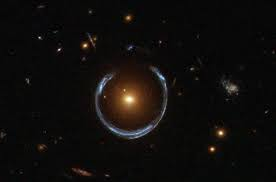

So now we define our "simulator."

In [89]:
def image_model(radius = 0.5, sigma = 0.3, width = 0.15, n = 1):
    x = np.linspace(-2, 2, 32)
    X, Y = np.meshgrid(x, x)
    
    # Random position of the ring
    imgs = []
    for i in range(n):
      x0, y0 = np.random.uniform(-1, 1, 2)

      R = ((X-x0)**2 + (Y-y0)**2)**0.5
      img = np.exp(-(R-radius)**2/width**2/2)
      img = img

      imgs.append(img)
    
    # Standard variance and zero mean
    img = sum(imgs)

    # Remove mean and variance
    img -= img.mean()
    img /= img.std()

    # Add image noise
    img += np.random.randn(*img.shape)*sigma


    return img.reshape(1, 32, 32).astype(np.float32)  # Default CUDA tensors are float32

Next, we next generate our training and test data. In this case, 50000 examples.

In [90]:
ring_data = []
for i in range(50000):
  r = np.random.rand(1).astype(np.float32)
  img = image_model(n = 3, radius = r)
  ring_data.append((img, r))

class RingDataset(torch.utils.data.Dataset):
  def __init__(self, ring_data):
    self.ring_data = ring_data

  def __getitem__(self, idx):
    return self.ring_data[idx]

  def __len__(self):
    return len(self.ring_data)

ring_dataset_train = RingDataset(ring_data[:45000])
ring_dataset_test = RingDataset(ring_data[45000:])

We then instantiate the loaders.

In [91]:
batch_size_train = 64  # by default we use a minibatch size of 64 for training.
# You can leave it like that during the subsequent exercises.

batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(ring_dataset_train, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ring_dataset_test, batch_size=batch_size_test, shuffle=True)

In [92]:
examples = list(train_loader)
example_data, example_targets = examples[0]

And plot test examples.

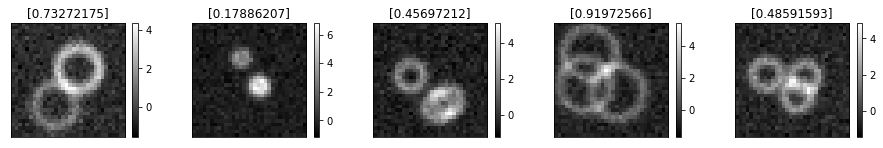

In [93]:
fig = plt.figure(figsize=(20, 10))
for i in range(5):
  plt.subplot(5,8,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("{}".format(example_targets[i].numpy()))
  plt.xticks([])
  plt.yticks([])
  plt.colorbar()


We first start with a regression-based implementation, where we will train a neural network to predict the radius as a single number directly.

1. Regression model. Adapt the CNN used on the MNIST dataset in the last homework to predict a single real-valued number that represents the radius. (2pt)

In [94]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5, padding=2)
    self.fc1 = nn.Linear(980, 50)
    #input size is50 output is 1 because 1 radius
    self.fc2 = nn.Linear(50, 1)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2(x), 2))
    #view means reshape if you are sure of the number of columns but not about 
    #the rows then you can specify this with a -1, 980 because it is a divisor of 62720
    x = x.view(-1, 980)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

2. Before, we were doing classification and so we used the appropriate cross-entropy loss. Now, we must replace the loss with mean square error (MSE) for regression. Define the training loop below with this new loss function. (1pt)

In [95]:
log_interval = 10

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data = data.to(DEVICE)
    target = target.to(DEVICE)
    output = network(data)
    criterion= nn.MSELoss()
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

3. Train the network on GPU. If everything works, you should see that the loss decreases. (Refer to previous exercises if you need guidance.) (2pt)

Hint: If your network doesn't train, try using a smaller learning rate (e.g. 0.001).

In [96]:
learning_rate = 0.001
n_epochs = 3

if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

network = Net().to(DEVICE)  # We move the network to the GPU
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

for epoch in range(1, n_epochs + 1):
    train(epoch)



Train Epoch: 1 [0/45000 (0%)]	Loss: 0.471808
Train Epoch: 1 [640/45000 (1%)]	Loss: 0.071854
Train Epoch: 1 [1280/45000 (3%)]	Loss: 0.047233
Train Epoch: 1 [1920/45000 (4%)]	Loss: 0.026208
Train Epoch: 1 [2560/45000 (6%)]	Loss: 0.016666
Train Epoch: 1 [3200/45000 (7%)]	Loss: 0.013035
Train Epoch: 1 [3840/45000 (9%)]	Loss: 0.010689
Train Epoch: 1 [4480/45000 (10%)]	Loss: 0.011154
Train Epoch: 1 [5120/45000 (11%)]	Loss: 0.010108
Train Epoch: 1 [5760/45000 (13%)]	Loss: 0.008069
Train Epoch: 1 [6400/45000 (14%)]	Loss: 0.005391
Train Epoch: 1 [7040/45000 (16%)]	Loss: 0.008290
Train Epoch: 1 [7680/45000 (17%)]	Loss: 0.008528
Train Epoch: 1 [8320/45000 (18%)]	Loss: 0.007152
Train Epoch: 1 [8960/45000 (20%)]	Loss: 0.004980
Train Epoch: 1 [9600/45000 (21%)]	Loss: 0.007561
Train Epoch: 1 [10240/45000 (23%)]	Loss: 0.004378
Train Epoch: 1 [10880/45000 (24%)]	Loss: 0.004081
Train Epoch: 1 [11520/45000 (26%)]	Loss: 0.004932
Train Epoch: 1 [12160/45000 (27%)]	Loss: 0.003549
Train Epoch: 1 [12800/45000

4. Illustrate the reconstruction quality by running 1000 test images through the network and recording the outputs.  Show correct (x-axis) vs reconstructed (y-axis) radii in a scatter plot (`plt.scatter`). How well does your network perform? (1pt)

Text(0.5, 0, 'correct')

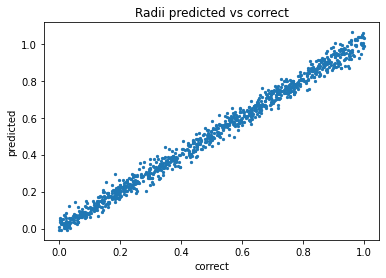

In [97]:
examples = list(test_loader)
example_data, example_targets = examples[0]
example_data = example_data.to(DEVICE)

pred = network(example_data)

pred = pred.cpu()
pred = pred.detach().numpy()

plt.scatter(example_targets, pred, s=5)
plt.title('Radii predicted vs correct')
plt.ylabel('predicted')
plt.xlabel('correct')

Seems to work pretty good since the correct radii and reconstructed radii are correlated in the graph.


5. Imagine your are provided with a single image, and you have to use your network to estimate the radius of the rings and quote your best estimate together with error bars. Write 2-3 qualitative sentences about how you could obtain this error bar from the plot that you generated in the previous point. (1pt)

You could use the 95% confidence interval, which gives a range (the error bar) around the best estimate in which the real radius will be with 95% confidence. This can be calculated with the following formula:
$x \pm \frac{1.96 σ} {\sqrt{n}}$. Where n is the number of samples and the standard deviation of the residuals which is the information of how the data points spread around the linear regression line (so you need to make a linear regression line).

### 2. Simulation-based inference of posteriors (9 pt + 3 bonus pt)

In the previous exercise, we predicted a single value for the radius, but this did not tell us anything about the probability of the predicted value. In this exercise, we will use the neural likelihood-free based inference method (focusing on neural ratio estimation) discussed in class to obtain proper Bayesian posteriors for the radius, instead of just a point estimator.

Let's start by defining a neural network that takes as input both an image $x$ as well as a label (in our case radius) $z$.  The output will be the probability that $x$ and $z$ are jointly drawn, $x, z \sim p(x, z)$, rather than marginally, $x, z \sim p(x)p(z)$.

In [98]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(501, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x, z):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 500)
        #print(x.shape)
        #print(z.shape)
        x = torch.cat((x, z), axis = 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

1. What does the `torch.cat` function do in this context? Relate it back to the math dicussed in class.  (1 pt)

torch.cat: concatenates the given tesnors with eachother. \
In this context we have a tensor x with 500 items and you concatenate that with a tensor of 1 item to get a tensor of 501 items. The 500 items came from the CNN and the single parameter is the radius z. This all relates as following to the math from class in the following way: \
$f_ϕ(x,z)=MLP_ϕ(v=con(s=F_ϕ(x),z))$ \
where torch.cat: $con(s=F_ϕ(x),z)$


Now we define the optimizer, and instantiate the network.

In [99]:
learning_rate = 0.001

network = Net().to(DEVICE)  # We move the network to the GPU
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

By default, we will use `n_epochs = 3` throughout.  Leave it like that.

In [100]:
n_epochs = 3  # 3 epochs by default. 

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

This is the main training loop is now given as follows.

In [101]:
log_interval = 10

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data = data.to(DEVICE)
    target = target.to(DEVICE)

    output_joined = network(data[1:], target[1:])
    output_marginal = network(data[1:], torch.randn_like(target[1:]))

    loss = -torch.log(output_joined) - torch.log(1-output_marginal)
    loss = loss.sum()

    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

2. Explain the role of the two different `output` variables, and how those enter the binary cross-entropy loss function. Write down the mathematical definition of the loss function that we implement (in terms of an integral). (1 pt)


The binary cross-entropy loss function is: \
$L[f_ϕ(x,z)] = -∫dxdz[p(x,z)ln(σ(f_ϕ(x,z)))  + p(x)p(z)ln(σ(-f_ϕ(x,z)))]$


In [102]:
for epoch in range(1, n_epochs + 1):
  train(epoch)

Train Epoch: 1 [0/45000 (0%)]	Loss: 87.233795
Train Epoch: 1 [640/45000 (1%)]	Loss: 86.659897
Train Epoch: 1 [1280/45000 (3%)]	Loss: 86.153770
Train Epoch: 1 [1920/45000 (4%)]	Loss: 85.505188
Train Epoch: 1 [2560/45000 (6%)]	Loss: 84.786697
Train Epoch: 1 [3200/45000 (7%)]	Loss: 85.620789
Train Epoch: 1 [3840/45000 (9%)]	Loss: 85.015694
Train Epoch: 1 [4480/45000 (10%)]	Loss: 81.995415
Train Epoch: 1 [5120/45000 (11%)]	Loss: 83.813446
Train Epoch: 1 [5760/45000 (13%)]	Loss: 82.444244
Train Epoch: 1 [6400/45000 (14%)]	Loss: 82.574127
Train Epoch: 1 [7040/45000 (16%)]	Loss: 81.782555
Train Epoch: 1 [7680/45000 (17%)]	Loss: 76.662659
Train Epoch: 1 [8320/45000 (18%)]	Loss: 77.205193
Train Epoch: 1 [8960/45000 (20%)]	Loss: 76.943008
Train Epoch: 1 [9600/45000 (21%)]	Loss: 78.336456
Train Epoch: 1 [10240/45000 (23%)]	Loss: 75.534103
Train Epoch: 1 [10880/45000 (24%)]	Loss: 75.672508
Train Epoch: 1 [11520/45000 (26%)]	Loss: 67.866608
Train Epoch: 1 [12160/45000 (27%)]	Loss: 72.013924
Train E

3. Write some code to plot, for a given image, the posterior of the radius. To this end, the network should be evaluated for the same $x$ and for a continuous range of $z$'s (i.e. radii).  Plot the posterior for 10 different images, together with the true values as a vertical line (`plt.axvline`). Hint: check how the data were generated to remind yourself of the allowed radii in our synthetic dataset. Make sure to correctly normalize the posterior to one (neural ratio estimation provides posteriors that are only approximately normalized to one). (3 pt)

In [103]:
example_targets = example_targets.detach().numpy()

0.21456692259705748


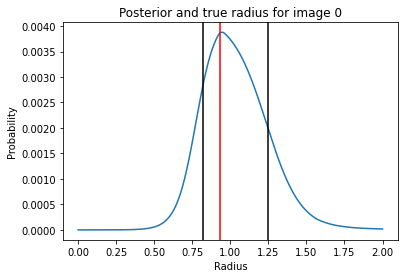

0.2087209345478231


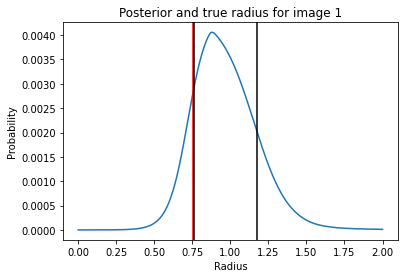

0.21376457372790417


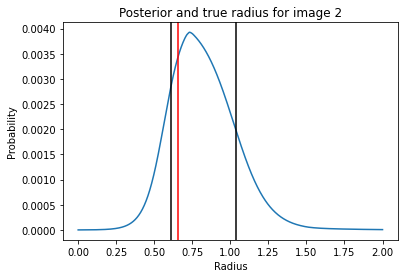

0.20307585033678968


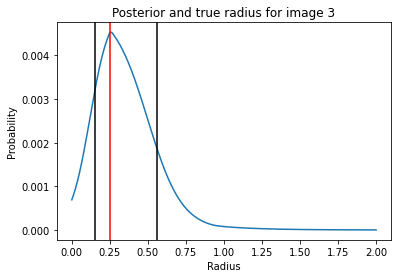

0.20555948155843667


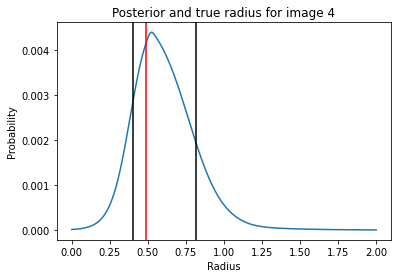

0.21123423735139843


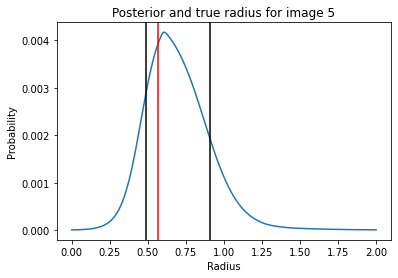

0.19180691655781534


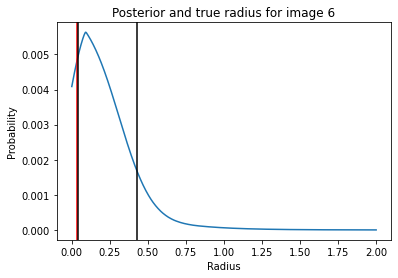

0.20434893511784108


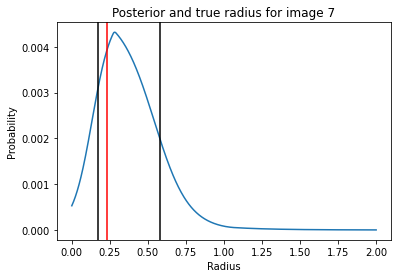

0.1936389986707067


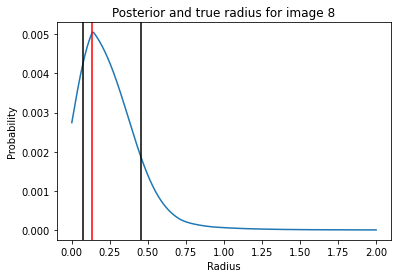

0.20253879208950154


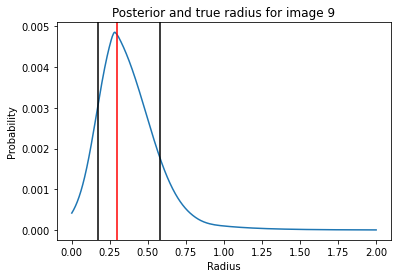

In [112]:
data_points = 1000
n_images = 10


for i in range(n_images):
  one_image = example_data[i].view((1,1,32,32))

  #from 0 to 2 to have full range if image has radius of 1
  z = torch.linspace(0,2,data_points)
  z = z.view(-1,1,1)
  z = z.to(DEVICE)

  #prediction posterior
  pred_range = np.array([])
  for j in range(data_points):
    pred = network(one_image, z[j])
    pred = pred.cpu().detach().numpy()
    pred_range = np.append(pred_range, pred)

  #normalization
  pred_range = pred_range/np.sum(pred_range)

  z = torch.Tensor.cpu(z)
  z = z.detach().numpy()
  z = z.reshape(data_points)

  average = np.array([])
  for k in range(data_points):
    avg = pred_range[k]*z[k]
    average = np.append(average, avg)
  
  average = np.sum(average)

  variance = np.array([])
  for l in range(data_points):
    var = pred_range[l]*(z[l]-average)**2
    variance = np.append(variance, var)

  variance = np.sum(variance)
  std = np.sqrt(variance)


  #68 credible interval is 1std away from the mean
  CI68 = std

  CIup = average + CI68
  CIdown = average - CI68

  plt.plot(z, pred_range)

  plt.axvline(example_targets[i], color='red')
  plt.axvline(CIup, color='black')
  plt.axvline(CIdown, color='black')
  plt.title(f'Posterior and true radius for image {i}')
  plt.xlabel('Radius')
  plt.ylabel('Probability')
  plt.show()


4. For each image in the test dataset, derive a posterior and then the boundaries of the 68% credible interval (highest posterior density interval). Next, since our test dataset contains 1000 examples, calculate the fraction of the test examples where the true value lies within the 68% containment interval of the posterior predicted by the neural network. Report this value. Lastly, visualize this by plotting, for each example in the test dataset, a black vertical line representing the containment interval on a plot where the x_axis indicates the true values of the radius and the y-axis represens the NN-predicted values. (4 pts) 

Hint: your plot should look something like this in the end:

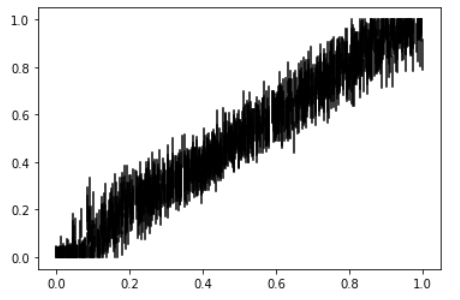

In [105]:
data_points = 200
n_images = 1000

averages = np.array([])
CIs = np.array([])
counter = 0
for i in range(n_images):
  one_image = example_data[i].view((1,1,32,32))

  #from 0 to 2 to have full range if image has radius of 1
  z = torch.linspace(0,2,data_points)
  z = z.view(-1,1,1)
  z = z.to(DEVICE)

  #prediction posterior
  pred_range = np.array([])
  for j in range(data_points):
    pred = network(one_image, z[j])
    pred = pred.cpu().detach().numpy()
    pred_range = np.append(pred_range, pred)

  #normalization
  pred_range = pred_range/np.sum(pred_range)

  z = torch.Tensor.cpu(z)
  z = z.detach().numpy()
  z = z.reshape(data_points)

  average = np.array([])
  for k in range(data_points):
    avg = pred_range[k]*z[k]
    average = np.append(average, avg)
  
  average = np.sum(average)
  averages = np.append(averages, average)

  variance = np.array([])
  for l in range(data_points):
    var = pred_range[l]*(z[l]-average)**2
    variance = np.append(variance, var)

  variance = np.sum(variance)
  std = np.sqrt(variance)

  #68 credible interval is 1std away from the mean
  CI68 = std
  CIs = np.append(CIs, CI68)

  CIup = average + CI68
  CIdown = average - CI68

  if CIdown < example_targets[i] < CIup:
    counter +=1

print('fraction of predictions that fall in the 68% containment interval of the posterior:', counter/len(example_targets))

fraction of predictions that fall in the 68% containment interval of the posterior: 0.923


Text(0.5, 1.0, 'Predict vs actual values with 68% credible interval')

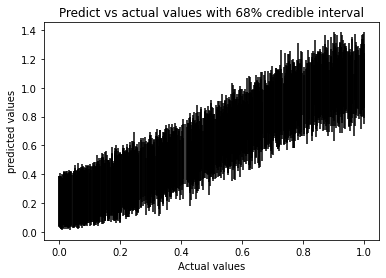

In [106]:
plt.errorbar(example_targets, averages, yerr=CIs, ls='none', ecolor='black')
plt.xlabel('Actual values')
plt.ylabel('predicted values')
plt.title('Predict vs actual values with 68% credible interval')



### 3. Properties of the KL divergence (9 pt + 4 bonus pt)

During the lecture you have learnt about the Kullback-Leibler divergence, a statistical distance that measures how one target probability distribution $P$ is different from a reference probability distribution $Q$. In this exercise we will explore some of its properties.

Let's assume your target distribution $P(x)$ is a mixture model of two Gaussians. An implementation is given as follow. Leave the means and variances parameters as given.

In [107]:
def p(x, mu1=-3, mu2=5, sigma1=1, sigma2=2, prob=0.5):
  gauss1 = torch.distributions.Normal(mu1,sigma1)
  gauss2 = torch.distributions.Normal(mu2,sigma2)
  return prob * gauss1.log_prob(x).exp() + (1-prob) * gauss2.log_prob(x).exp()

1. Write your $Q(x)$ distribution as a simple gaussian. The Gaussian PDF function will take as input parameters where it is evaluated `x`, the mean `mu` and the variance `sigma`. `mu` and `sigma` will be the parameters we are going to optimize. (1 pt)


In [108]:
def q(x, mu, sigma):
  gauss = torch.distributions.Normal(mu,sigma)

  return  gauss.log_prob(x).exp()

2. Create an array of points $x$ where to evaluate the two distributions $P(x)$ and $Q(x)$ in order to be able to visualize them on a plot (i.e. must include the mean values defined above for the gaussian mixture distribution). Choose initial values of `mu` and `sigma` for $Q(x)$. Plot $P(x)$ and $Q(x)$. (1 pt)

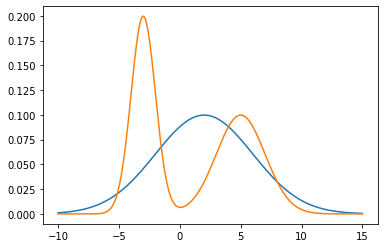

In [109]:
x = torch.linspace(-10, 15, 1000)
Q_x = q(x,2,4)
P_x = p(x)
plt.plot(x, Q_x)
plt.plot(x, P_x)

3. Implement your forward and reverse KL divergence. To perform the integration use `torch.trapezoid`, carefully read its [documentation](https://pytorch.org/docs/stable/generated/torch.trapezoid.html#torch.trapezoid). Compute the forward and reverse KL divergence between the two distributions. Discuss why the KL divergence is not a distance metric. (3 pt)

Hint: if you get Nan or Inf value it's due to numerical instability. Try adding a *small* (e.g. $10^{-20}$) constant to the probability densities where necessary to avoid it.

In [110]:
dx = (abs(min(x)) + abs(max(x))) / (len(x) - 1)

kl1 = torch.trapezoid(P_x* np.log(P_x/(Q_x+ 10**-20)), dx = dx)
print(kl1)

kl2 = torch.trapezoid(Q_x* np.log(Q_x/(P_x + 10**-20)), dx = dx)
print(kl2)

tensor(0.4672)
tensor(0.6491)


KL divergerence is not a distance metric, because it is not symmetric the KL from p(x) to q(x) is generally not the same as the KL of p(x) to q(x).


4. In order to optimize the mean and variance of our reference distribution $Q$, evaluate on a grid of `mu` and `sigma` values the forward and the reverse KL divergence. Visualize the grids for the forward and the reverse KL divergence using `plt.imshow` and **carefully** read its documentation to plot it correctly (100 points in the grid will be enough). Discuss your results. What does this maps show you? When is it better to use forward KL divergence? When is it better to use reverse KL divergence? Why? (4 pt)

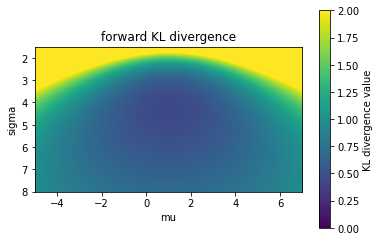

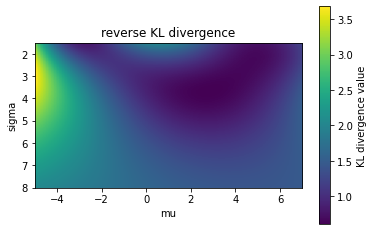

In [111]:
n_grid = 100

x = torch.linspace(-10, 15, 1000)

mu_min = -5
mu_max = 7
sigma_min = 1.5
sigma_max = 8
mus = torch.linspace(mu_min, mu_max, n_grid)
sigmas = torch.linspace(sigma_min, sigma_max, n_grid)

kl1s = np.array([])
kl2s = np.array([])
for sigma in sigmas:
  for mu in mus:
    Q_x = q(x, mu, sigma)
    #simple gaussian down then it is forward
    kl1 = torch.trapezoid(P_x* np.log((P_x)/(Q_x+10**-10)), dx=dx)
    #simpel gaussian up then it is reverse
    kl2 = torch.trapezoid(Q_x* np.log((Q_x)/(P_x+10**-10)), dx=dx)
    kl1 = kl1.detach().numpy()
    kl2 = kl2.detach().numpy()
    kl1s = np.append(kl1s, kl1)
    kl2s = np.append(kl2s, kl2)

kl1s = kl1s.reshape(100,100)
kl2s = kl2s.reshape(100,100)

plt.imshow(kl1s, extent = [mu_min, mu_max, sigma_max, sigma_min])
plt.colorbar(label="KL divergence value")
plt.clim(0, 2) 
plt.title('forward KL divergence')
plt.xlabel('mu')
plt.ylabel('sigma')
plt.show()

plt.imshow(kl2s, extent = [mu_min, mu_max, sigma_max, sigma_min])
plt.colorbar(label="KL divergence value")
#plt.clim(0, 100)
plt.title('reverse KL divergence')
plt.xlabel('mu')
plt.ylabel('sigma')
plt.show()




The two maps show the KL divergence (forward and reverse)  between $P(x)$ and $Q(x)$ for different values for $μ$ and $σ$ for the gaussian pdf of $Q$. \

The forward KL divergence becomes small when the mean of the function $Q$ is at around $1$ (which is the mean of the 2 input gaussian function of $P$) and with a standard deviation of around 4 so that the function $Q$ encompasses both peaks of function $P$. So using the forward divergence will give a general idea where the expectation value of the data lies but is not very precise for the specific peaks.

For the reverse KL divergence the value becomes small when the mean of function $Q$ is around 5 and -3 which are the means of the 2 input gaussian functions of $P$. This goes along with a small standard deviation so that the function $Q$ encompasses that specific peak. When the std becomes larger is somewhere in the middle so that $Q$ again encompasses both input functions of $P$. So the reverse KL divergence can be used to find specfic peaks with more accuracy.
